In [1]:
import os, sys
import dotenv

import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append(os.environ.get('PATH_OPENSKY'))
from user_eval import get_df_posts 
from news_outlet_eval import get_news_feed, get_posts_from_nos

dotenv.load_dotenv('.env')    
PATH_DATA = os.environ.get('PATH_OPENSKY') + os.environ.get('PATH_REL_DATA')
PATH_USER_POSTS = PATH_DATA + 'user_posts/'

PATH_RESULTS = os.environ.get('PATH_OPENSKY') + 'results/'
PATH_USER_REPLIES_NEWS_POSTS = PATH_RESULTS + 'agg_user_replies_news_posts_2.csv'
PATH_ALL_SENTIMENTS = os.environ.get('PATH_OPENSKY') + 'results/all_sentiments_over_time.csv'

COLOR_POSITIVE = os.environ.get('COLOR_POSITIVE')
COLOR_NEUTRAL = os.environ.get('COLOR_NEUTRAL')
COLOR_NEGATIVE = os.environ.get('COLOR_NEGATIVE')


In [2]:
df_news_posts = pd.read_csv(PATH_USER_REPLIES_NEWS_POSTS)
bm_first_depth = (df_news_posts.reply_to == df_news_posts.thread_root)
df_news_posts = df_news_posts[bm_first_depth]
df_news_posts.dropna(subset=['sent_label'], inplace=True)
df_news_posts['date'] = pd.to_datetime(df_news_posts['date'], errors='coerce')

sent_label_mapping = { 0: 'negative', 1: 'neutral', 2: 'positive'}
df_news_posts.loc[:, 'sent_label'] = df_news_posts.sent_label.map(sent_label_mapping)
df_news_posts

/tmp/ipykernel_12083/4123129271.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_news_posts = pd.read_csv(PATH_USER_REPLIES_NEWS_POSTS)
/tmp/ipykernel_12083/4123129271.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['positive' 'positive' 'neutral' ... 'negative' 'negative' 'neutral']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_news_posts.loc[:, 'sent_label'] = df_news_posts.sent_label.map(sent_label_mapping)


,post_id,user_id,instance,date,text,langs,like_count,reply_count,repost_count,reply_to,replied_author,thread_root,thread_root_author,repost_from,reposted_author,quotes,quoted_author,labels,sent_label,sent_score
0,10657080,284413,bsky.social,2024-01-14 08:03:00,let’s hope his expands ten fold 💪💪,['eng'],0,0,0,10657081.0,15717.0,10657081.0,15717.0,NaN,NaN,NaN,NaN,NaN,positive,0.945
1,10657084,284413,bsky.social,2024-01-12 22:12:00,"yes, we can do this! 💪",['eng'],3,0,0,5595208.0,2486.0,5595208.0,2486.0,NaN,NaN,NaN,NaN,NaN,positive,0.956
2,10657085,284413,bsky.social,2024-01-11 14:19:00,"in other words, “as long as it takes” it refer...",['eng'],0,1,0,10657086.0,12030.0,10657086.0,12030.0,NaN,NaN,NaN,NaN,NaN,neutral,0.583
3,10657096,284413,bsky.social,2024-01-08 14:10:00,i’ll believe it when i see the weapons in Ukra...,['eng'],0,0,0,10657097.0,15717.0,10657097.0,15717.0,NaN,NaN,NaN,NaN,NaN,neutral,0.509
4,10657117,284413,bsky.social,2024-01-05 09:22:00,Expect the world to become way way worse. If a...,['eng'],1,0,0,5271912.0,15717.0,5271912.0,15717.0,NaN,NaN,NaN,NaN,NaN,negative,0.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36812,110584107,527683,bsky.social,2023-10-06 20:06:00,Are you kidding?\n\nThere are always people wh...,['eng'],3,1,0,4108566.0,379.0,4108566.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.929
36817,105014318,92560,bsky.social,2024-03-08 01:59:00,What a complete abdication of good journalism ...,['eng'],0,0,0,698597.0,9.0,698597.0,9.0,NaN,NaN,NaN,NaN,NaN,negative,0.790
36818,105014322,92560,bsky.social,2024-03-07 22:16:00,Trump and Biden are at par with age...exactly ...,['eng'],4,0,0,127576.0,379.0,127576.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.867
36819,105014501,92560,bsky.social,2024-01-05 08:08:00,Because doctors are literally refusing to pres...,['eng'],1,0,0,145919.0,379.0,145919.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.882


In [3]:
df_news_posts.reply_to.nunique()

5678

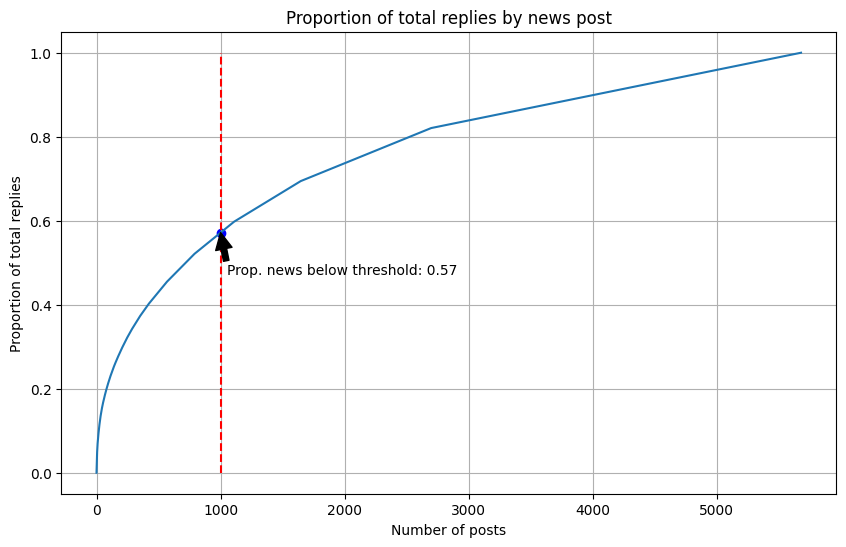

In [4]:
reply_counts = df_news_posts.groupby('reply_to').size().sort_values(ascending=False).reset_index(name='count')

# Calculate the cumulative sum
cumulative_replies = reply_counts['count'].cumsum()
cumulative_replies = cumulative_replies / cumulative_replies.max()
origin = pd.Series([0])
cumulative_replies = pd.concat([origin, cumulative_replies]).reset_index(drop=True)

# Plot the cumulative sum
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cumulative_replies)
ax.set_xlabel('Number of posts')
ax.set_ylabel('Proportion of total replies')
ax.set_title('Proportion of total replies by news post')

news_reply_threshold = 1000
ax.vlines(news_reply_threshold, 0, 1, color='red', linestyle='--')

intersection_y = cumulative_replies.iloc[news_reply_threshold] if news_reply_threshold < len(cumulative_replies) else 1
ax.scatter(news_reply_threshold, intersection_y, color='blue')
ax.annotate(f'Prop. news below threshold: {intersection_y:.2f}', 
            xy=(news_reply_threshold, intersection_y), 
            xytext=(news_reply_threshold + 50, intersection_y - 0.1),
            arrowprops=dict(facecolor='black', shrink=1))

ax.grid(True)

In [5]:
reply_counts.iloc[news_reply_threshold]

reply_to    911540.0
count            4.0
Name: 1000, dtype: float64

In [6]:
relevant_news_posts = reply_counts.head(news_reply_threshold).reply_to.values
df_news_posts = df_news_posts[df_news_posts.reply_to.isin(relevant_news_posts)]
df_news_posts

,post_id,user_id,instance,date,text,langs,like_count,reply_count,repost_count,reply_to,replied_author,thread_root,thread_root_author,repost_from,reposted_author,quotes,quoted_author,labels,sent_label,sent_score
22,10657231,284413,bsky.social,2023-12-30 16:52:00,"and by the way, NYT, gtfo, you disgusting russ...",['eng'],8,0,0,10657232.0,379.0,10657232.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.945
23,10657233,284413,bsky.social,2023-12-30 16:41:00,"ah, yes…NYT. Unfortunately only 14..but hopefu...",['eng'],7,1,0,10657232.0,379.0,10657232.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.921
27,10657281,284413,bsky.social,2023-12-24 15:29:00,Reminds me of,['eng'],3,0,0,705616.0,379.0,705616.0,379.0,NaN,NaN,NaN,NaN,NaN,neutral,0.699
45,10657446,284413,bsky.social,2023-12-09 15:01:00,jesus christ… this is straight from medieval t...,['eng'],1,0,0,3158145.0,379.0,3158145.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.825
68,10657677,284413,bsky.social,2023-11-22 17:34:00,progressive..more like pro-hamas,['eng'],0,2,0,10657678.0,16202.0,10657678.0,16202.0,NaN,NaN,NaN,NaN,NaN,neutral,0.780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36812,110584107,527683,bsky.social,2023-10-06 20:06:00,Are you kidding?\n\nThere are always people wh...,['eng'],3,1,0,4108566.0,379.0,4108566.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.929
36817,105014318,92560,bsky.social,2024-03-08 01:59:00,What a complete abdication of good journalism ...,['eng'],0,0,0,698597.0,9.0,698597.0,9.0,NaN,NaN,NaN,NaN,NaN,negative,0.790
36818,105014322,92560,bsky.social,2024-03-07 22:16:00,Trump and Biden are at par with age...exactly ...,['eng'],4,0,0,127576.0,379.0,127576.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.867
36819,105014501,92560,bsky.social,2024-01-05 08:08:00,Because doctors are literally refusing to pres...,['eng'],1,0,0,145919.0,379.0,145919.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.882


In [7]:
num_sent_replies = df_news_posts.groupby(['reply_to', 'sent_label']).size().unstack()

normalized_df = num_sent_replies.apply(lambda x: x / x.sum(), axis=1)

if 'negative' in normalized_df.columns:
    normalized_df = normalized_df.sort_values(by='negative', ascending=False)
    

In [8]:
color_map = {
    'positive': COLOR_POSITIVE,
    'neutral': COLOR_NEUTRAL,
    'negative': COLOR_NEGATIVE
}

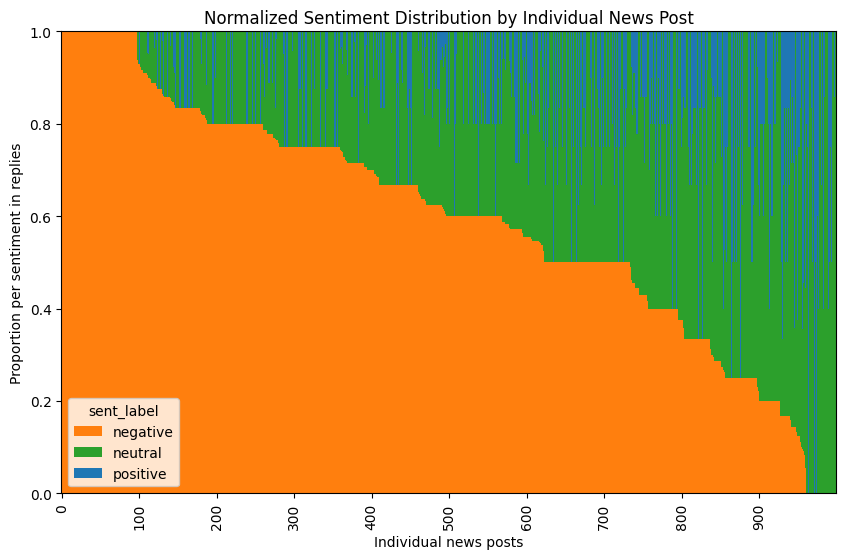

In [9]:
ax = normalized_df.plot(kind='bar', stacked=True, figsize=(10, 6), width=1, edgecolor='none', color=[color_map[col] for col in normalized_df.columns])
ax.set_xlabel('Individual news posts')
ax.set_ylabel('Proportion per sentiment in replies')
ax.set_title('Normalized Sentiment Distribution by Individual News Post')

ax.set_ylim(0,1)

xticks = range(0, len(normalized_df), 100)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)

plt.show()